In [10]:
## Loading Dataset

In [11]:
!pip install --upgrade --no-cache-dir gdown

In [12]:
# https://drive.google.com/file/d/165xgQLtDneDmHmUkRlzS0Xn7G5N8zTSb/view?usp=sharing
!gdown 165xgQLtDneDmHmUkRlzS0Xn7G5N8zTSb


Downloading...
From (original): https://drive.google.com/uc?id=165xgQLtDneDmHmUkRlzS0Xn7G5N8zTSb
From (redirected): https://drive.google.com/uc?id=165xgQLtDneDmHmUkRlzS0Xn7G5N8zTSb&confirm=t&uuid=337c3cb2-5413-454b-9eba-0592369816d3
To: C:\Users\Ahmed\USD\AA 501\Image-recognition-of-Breast-Cancer-\archive.zip

  0%|          | 0.00/204M [00:00<?, ?B/s]
  0%|          | 524k/204M [00:00<00:53, 3.84MB/s]
  1%|1         | 2.10M/204M [00:00<00:20, 9.82MB/s]
  2%|2         | 4.19M/204M [00:00<00:15, 12.8MB/s]
  4%|3         | 7.34M/204M [00:00<00:10, 18.5MB/s]
  5%|4         | 9.96M/204M [00:00<00:10, 18.2MB/s]
  6%|6         | 12.6M/204M [00:00<00:09, 19.6MB/s]
  8%|7         | 15.7M/204M [00:00<00:08, 22.6MB/s]
  9%|8         | 18.4M/204M [00:01<00:09, 19.3MB/s]
 11%|#1        | 22.5M/204M [00:01<00:07, 24.5MB/s]
 13%|#2        | 25.7M/204M [00:01<00:07, 25.1MB/s]
 14%|#4        | 28.8M/204M [00:01<00:07, 24.4MB/s]
 15%|#5        | 31.5M/204M [00:01<00:07, 23.9MB/s]
 17%|#6        | 34.1M

In [13]:
!mkdir "BSUI"

A subdirectory or file BSUI already exists.


In [14]:
!unzip -u "/content/archive.zip" -d "BSUI"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
!pip install tf-explain

In [16]:
## Importing Libraries

In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, MaxPooling2D, Dropout, UpSampling2D,
    concatenate, Add, Multiply, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt
from glob import glob


ModuleNotFoundError: No module named 'tensorflow'

In [7]:
# Set paths
SIZE = 256
ROOT_PATH = "/content/BSUI/Dataset_BUSI_with_GT"
CLASSES = sorted(os.listdir(ROOT_PATH))

In [8]:
for name in CLASSES:
    path = os.path.join(ROOT_PATH, name, "/*mask.png")
    print(path)

/*mask.png
/*mask.png
/*mask.png


In [9]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("No GPU detected. Using CPU.")

GPU detected: /device:GPU:0


In [10]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

In [11]:
# Load images and masks
def load_image(image_path, size, is_mask=False):
    image = img_to_array(load_img(image_path)) / 255.0
    image = tf.image.resize(image, (size, size)).numpy()
    if is_mask:
        return image[:, :, :1]
    return image

def load_dataset(image_paths, mask_paths, size):
    images = np.array([load_image(img, size) for img in image_paths])
    masks = np.array([load_image(mask, size, is_mask=True) for mask in mask_paths])
    return images, masks

In [12]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

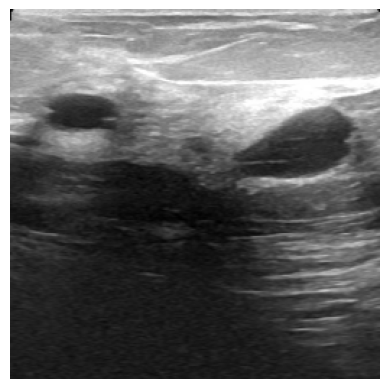

In [13]:
show_image(load_image(os.path.join(ROOT_PATH, 'benign/benign (100).png'), SIZE))

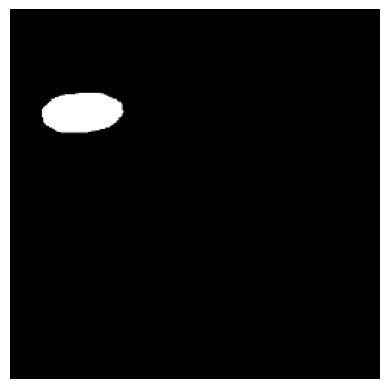

In [14]:
show_image(load_image(os.path.join(ROOT_PATH, 'benign/benign (100)_mask_1.png'), SIZE))

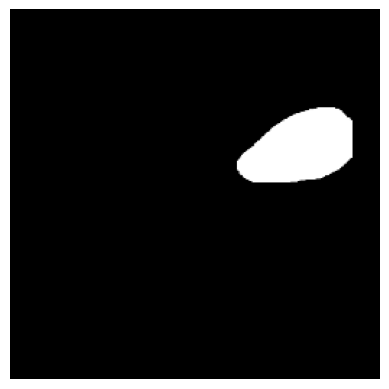

In [15]:
show_image(load_image(os.path.join(ROOT_PATH, 'benign/benign (100)_mask.png'), SIZE))

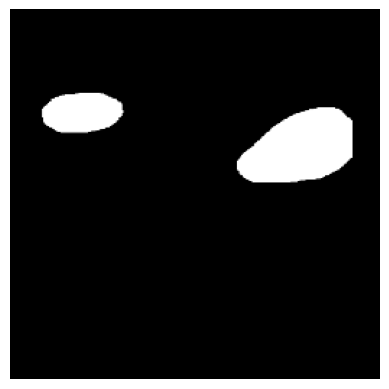

In [16]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image(os.path.join(ROOT_PATH, 'benign/benign (100)_mask_1.png'), SIZE)
mask2 = load_image(os.path.join(ROOT_PATH, 'benign/benign (100)_mask.png'), SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

In [17]:
image_paths = []
mask_paths = []

for class_name in CLASSES:
    masks = sorted(glob(os.path.join(ROOT_PATH, class_name, "*mask.png")))
    images = [mask.replace("_mask", "") for mask in masks]
    image_paths.extend(images)
    mask_paths.extend(masks)

images, masks = load_dataset(image_paths, mask_paths, SIZE)

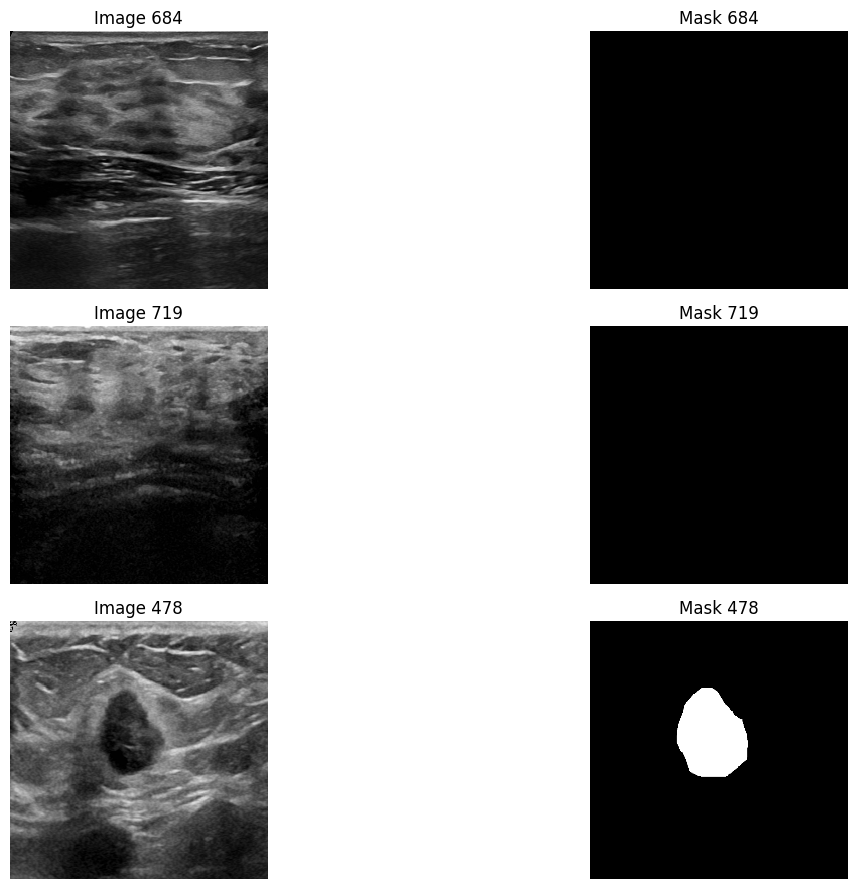

In [19]:
def plot_images_and_masks(images, masks, num_samples=5, cmap='gray'):
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        # Randomly select an image and its mask
        idx = np.random.randint(0, len(images))
        image = images[idx]
        mask = masks[idx]

        # Plot the image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image, interpolation='nearest')
        plt.title(f"Image {idx+1}")
        plt.axis('off')

        # Plot the mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask.squeeze(), cmap=cmap, interpolation='nearest')
        plt.title(f"Mask {idx+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with loaded images and masks
plot_images_and_masks(images, masks, num_samples=3)

In [20]:
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [21]:
single_mask_paths = [
    sorted(glob(os.path.join(ROOT_PATH, class_name, "*mask.png")))
    for class_name in CLASSES
]

double_mask_paths = [
    sorted(glob(os.path.join(ROOT_PATH, class_name, "*mask_1.png")))
    for class_name in CLASSES
]

In [22]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [23]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, UpSampling2D, Dropout, Add, Multiply, concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU

# Custom Encoder Block
class EncoderBlock(Layer):
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
            'pooling': self.pooling
        }

# Custom Decoder Block
class DecoderBlock(Layer):
    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            'rate': self.rate,
        }

# Custom Attention Gate
class AttentionGate(Layer):
    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        self.filters = filters
        self.bn = bn
        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X
        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters": self.filters,
            "bn": self.bn
        }

# Build the Model
input_layer = Input(shape=images.shape[1:])

# Encoder
p1, c1 = EncoderBlock(32, 0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256, 0.2, name="Encoder4")(p3)

# Bottleneck
encoding = EncoderBlock(512, 0.3, pooling=False, name="Bottleneck")(p4)

# Decoder with Attention
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256, 0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128, 0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64, 0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32, 0.1, name="Decoder4")([d3, a4])

# Output Layer
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(inputs=[input_layer], outputs=[output_layer])

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

# Callbacks
callbacks = [
    ModelCheckpoint("AttentionUNet.keras", save_best_only=True)
]

# Training Configuration
BATCH_SIZE = 8
SPE = len(images) // BATCH_SIZE

# Train the Model
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=10,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'Bottleneck', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder_block_1', however the layer does

Epoch 1/10
78/97 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - IoU: 0.4431 - accuracy: 0.8557 - loss: 0.4632

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - IoU: 0.4366 - accuracy: 0.8635 - loss: 0.4379 - val_IoU: 0.4909 - val_accuracy: 0.9813 - val_loss: 0.3568
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - IoU: 0.4357 - accuracy: 0.9076 - loss: 0.2600 - val_IoU: 0.4909 - val_accuracy: 0.9813 - val_loss: 0.2044
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - IoU: 0.4376 - accuracy: 0.9120 - loss: 0.2300 - val_IoU: 0.4909 - val_accuracy: 0.9755 - val_loss: 0.3200
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - IoU: 0.4355 - accuracy: 0.9167 - loss: 0.2146 - val_IoU: 0.4909 - val_accuracy: 0.9813 - val_loss: 0.0890
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - IoU: 0.4375 - accuracy: 0.9267 - loss: 0.1986 - val_IoU: 0.4909 - val_accuracy: 0.9794 - val_loss: 0.1564
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - IoU: 0.4326 - accuracy: 0.9250 - loss: 0.2031 - val_IoU: 0.4909 - val_accuracy: 0.9795 - val_loss: 0.2207
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 171

In [30]:
## Model Accuracy ans Loss

In [25]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

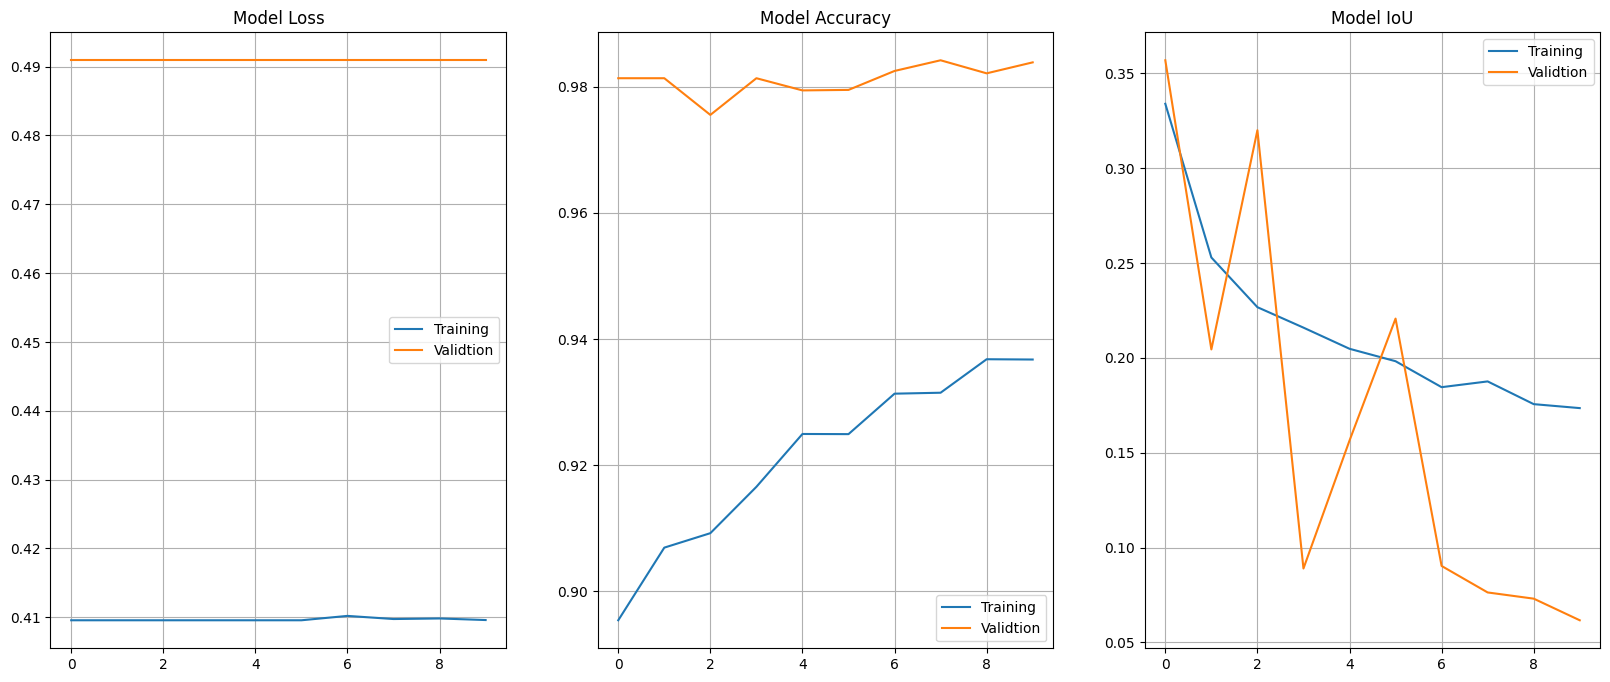

In [26]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [31]:
## Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


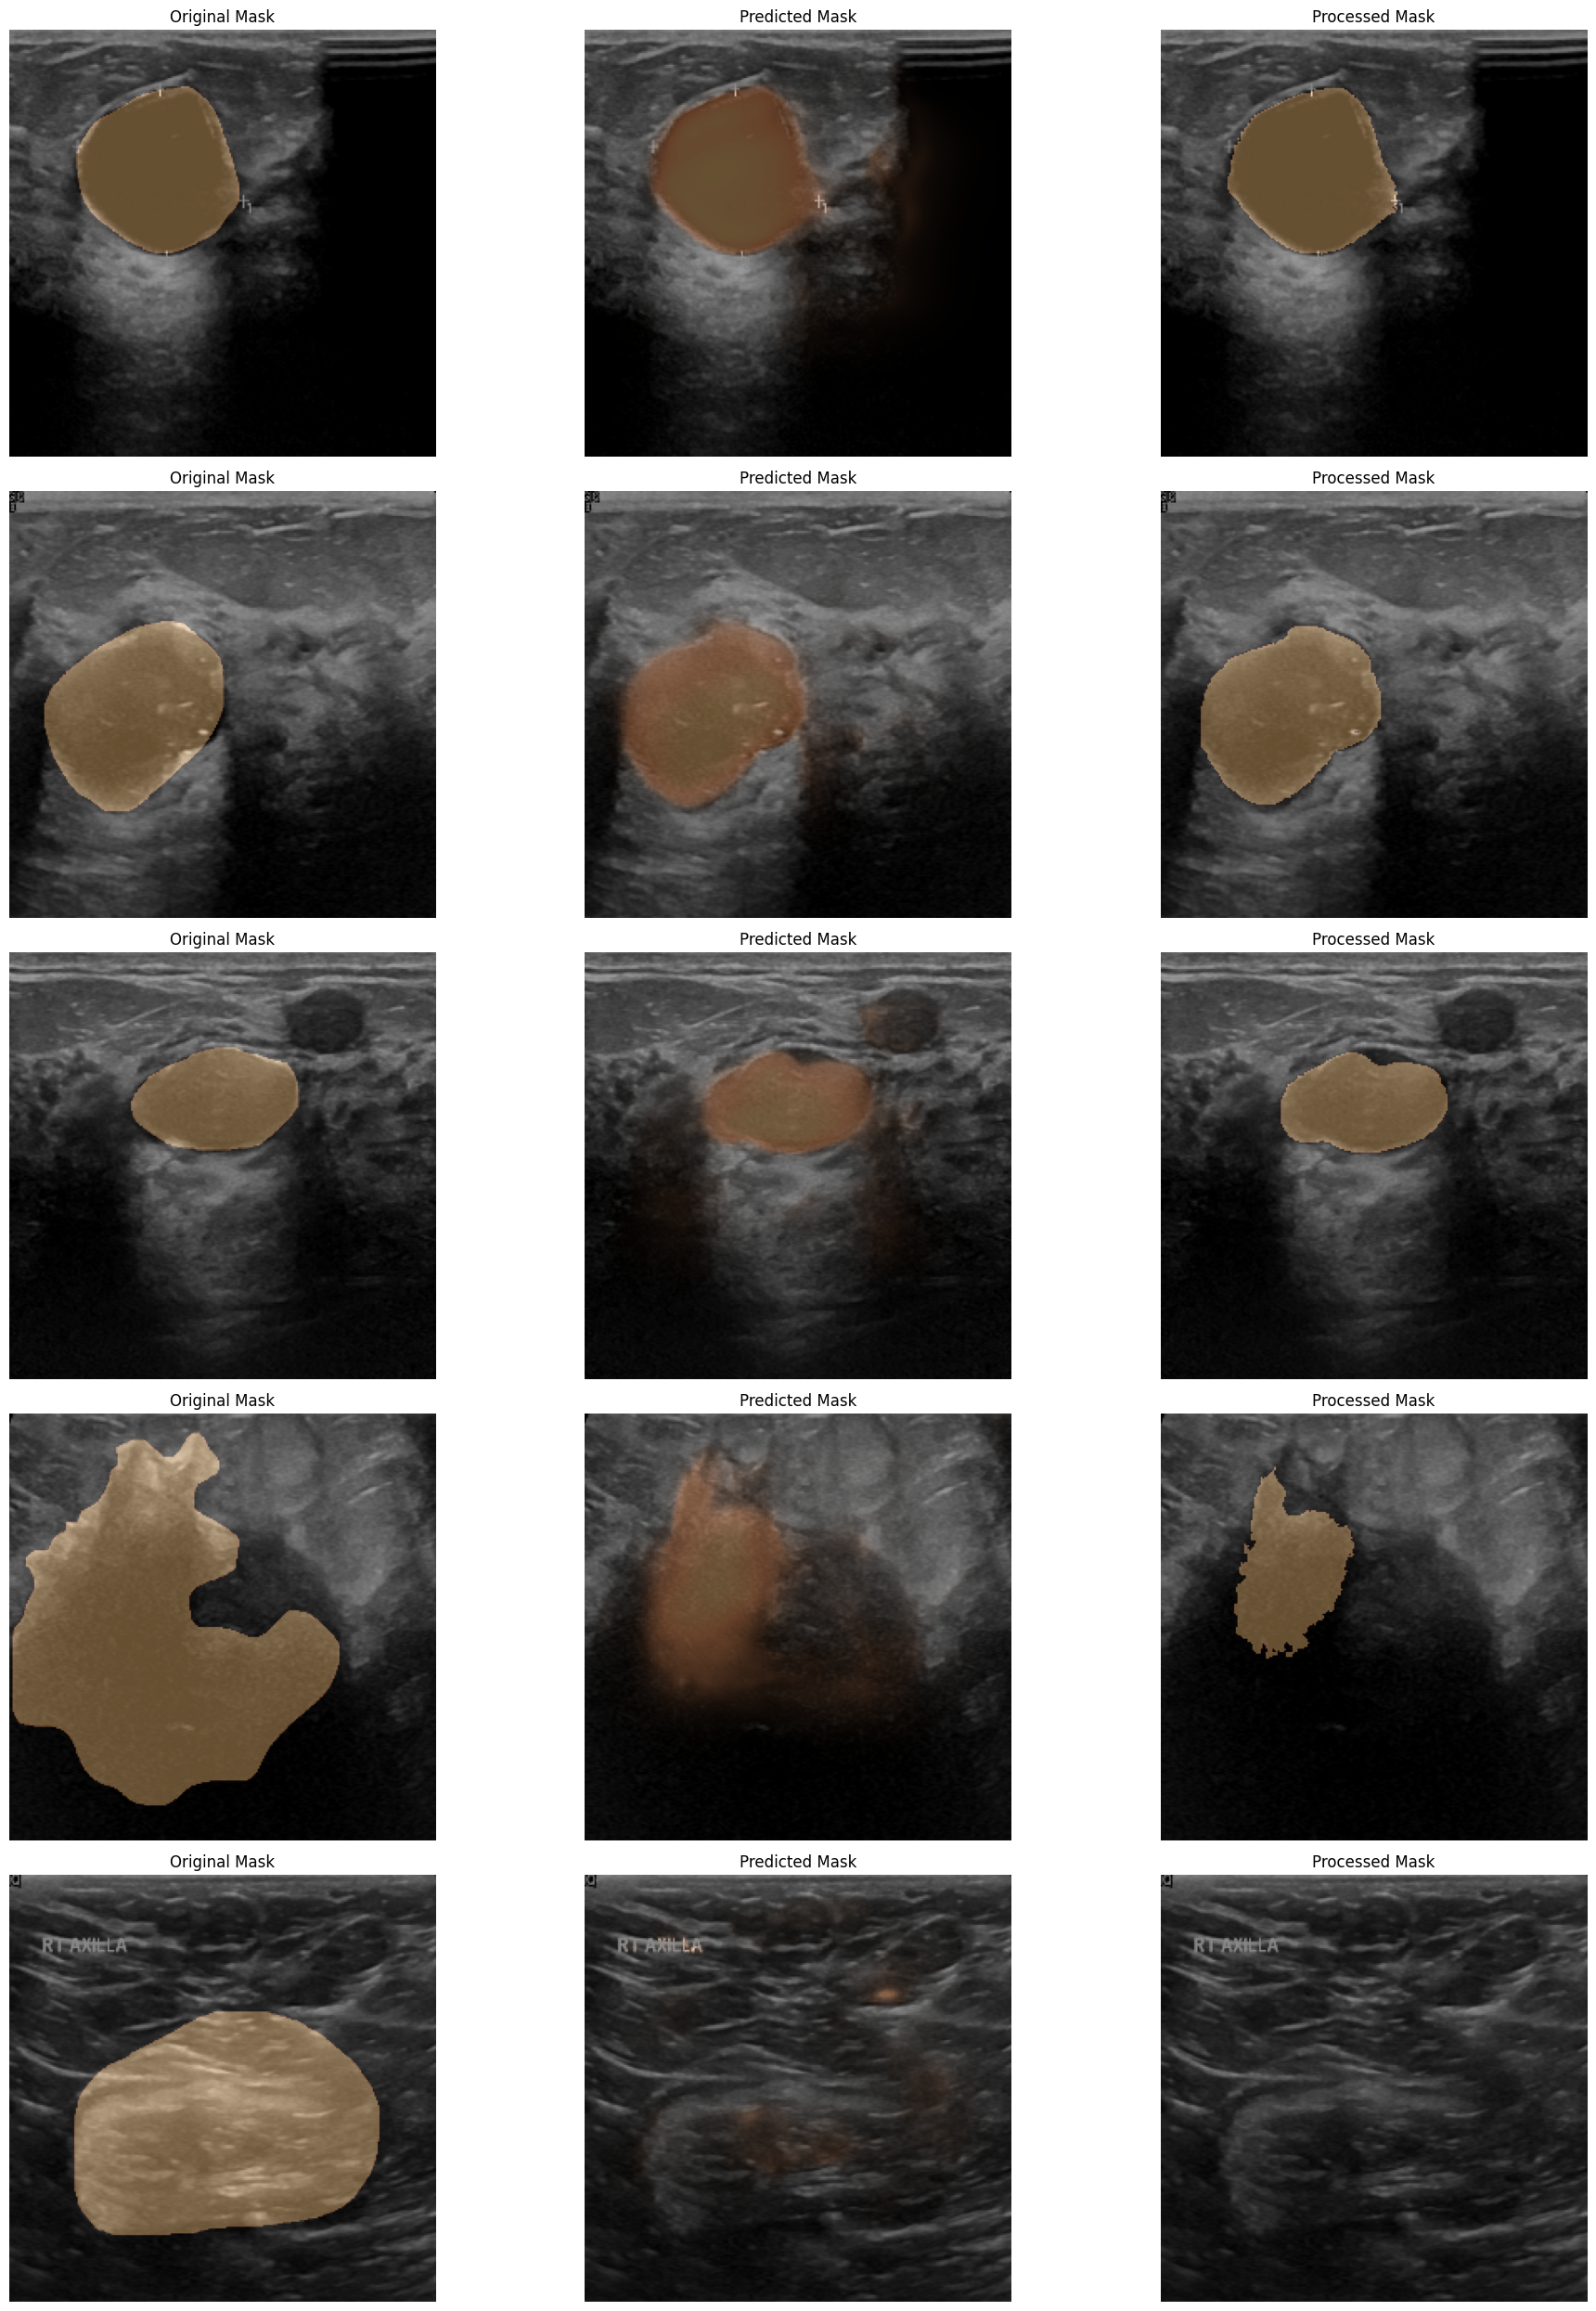

In [27]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        show_mask(image, pred_mask, cmap='copper')
        n=0
plt.tight_layout()
plt.show()